<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-low-level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks with Low Level TensorFlow 2

Based on 
* This thread is a crash course on everything you need to know to use TensorFlow 2.0 + Keras for deep learning research: https://twitter.com/fchollet/status/1105139360226140160
* Colab Notebook _tf.keras for Researchers_: https://colab.research.google.com/drive/17u-pRZJnKN0gO5XZmq8n5A2bKGrfKEUg#scrollTo=UHOOlixcQ9Gl
* Effective TensorFlow 2: https://www.tensorflow.org/alpha/guide/effective_tf2


In [0]:
# for colab, you might see an error, but never mind
!pip install -q tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190605


In [3]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [4]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
!nvidia-smi

Thu Jun  6 08:07:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |    129MiB / 15079MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
tf.executing_eagerly()

True

## Transforming an input to a known output

In [0]:
input = [[-1], [0], [1], [2], [3], [4]]
output = [[2], [1], [0], [-1], [-2], [-3]]

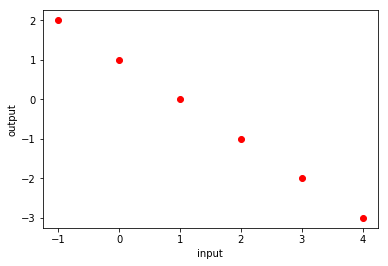

In [9]:
import matplotlib.pyplot as plt

plt.xlabel('input')
plt.ylabel('output')

plt.plot(input, output, 'ro')

### relation between input and output is linear

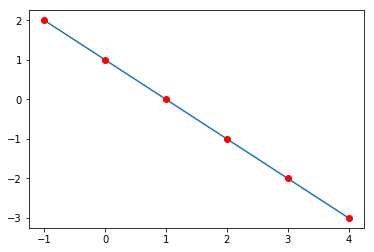

In [10]:
plt.plot(input, output)
plt.plot(input, output, 'ro')

## Defining the model to train

untrained single unit (neuron) also outputs a line from same input, although another one 

### The Artificial Neuron: Foundation of Deep Neural Networks (simplified, more later)

* a neuron takes a number of numerical inputs
* multiplies each with a weight, sums up all weighted input and  
* adds bias (constant) to that sum
* from this it creates a single numerical output
* for one input (one dimension) this would be a description of a line
* for more dimensions this describes a hyper plane that can serve as a decision boundary
* this is typically expressed as a matrix multplication plus an addition


<img src='https://djcordhose.github.io/ai/img/insurance/neuron211.jpg'>

### This can be expressed using a matrix multiplication

In [11]:
w = tf.constant([[1.5], [-2], [1]], dtype='float32')
x = tf.constant([[10, 6, 8]], dtype='float32')
b = tf.constant([6], dtype='float32')

y = tf.matmul(x, w) + b
print(y)

tf.Tensor([[17.]], shape=(1, 1), dtype=float32)


### Defining a layer with a random number of neurons and inputs

In [0]:
from tensorflow.keras.layers import Layer

class LinearLayer(Layer):
  """y = w.x + b"""

  def __init__(self, units=1, input_dim=1):
      super(LinearLayer, self).__init__()
      w_init = tf.random_normal_initializer(stddev=2)
      self.w = tf.Variable(
          initial_value = w_init(shape=(input_dim, units), dtype='float32'),
          trainable=True)
      b_init = tf.zeros_initializer()
      self.b = tf.Variable(
          initial_value = b_init(shape=(units,), dtype='float32'),
          trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b
    
linear_layer = LinearLayer()

### Output of a single untrained neuron

In [13]:
x = tf.constant(input, dtype=tf.float32)
y_true = tf.constant(output, dtype=tf.float32)
y_true

<tf.Tensor: id=31, shape=(6, 1), dtype=float32, numpy=
array([[ 2.],
       [ 1.],
       [ 0.],
       [-1.],
       [-2.],
       [-3.]], dtype=float32)>

In [14]:
y_pred = linear_layer(x)
y_pred

<tf.Tensor: id=36, shape=(6, 1), dtype=float32, numpy=
array([[ 1.5643244],
       [ 0.       ],
       [-1.5643244],
       [-3.1286488],
       [-4.692973 ],
       [-6.2572975]], dtype=float32)>

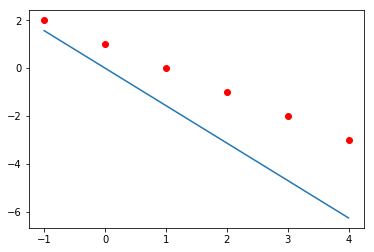

In [15]:
plt.plot(x, y_pred)
plt.plot(input, output, 'ro')

## Loss - Mean Squared Error

Loss function is the prerequisite to training. We need an objective to optimize for. We calculate the difference between what we get as output and what we would like to get.

### Mean Squared Error

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


In [0]:
loss_fn = tf.losses.mean_squared_error
# loss_fn = tf.losses.mean_absolute_error

In [17]:
loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
print(loss)

tf.Tensor(4.3383603, shape=(), dtype=float32)


In [18]:
tf.keras.losses.mean_squared_error == tf.losses.mean_squared_error

True

### Minimize Loss by changing parameters of neuron

Move in parameter space in the direction of a descent

<img src='https://djcordhose.github.io/ai/img/gradients.jpg'>

https://twitter.com/colindcarroll/status/1090266016259534848

### Job of the optimizer

<img src='https://djcordhose.github.io/ai/img/manning/optimizer.png' height=500>

### Backpropagation

1. Predict: Let the network make a prediction 
1. Calculate the loss: how accurate was the predition
1. partial derivations: Find out in which direction to change all parameters to bring down the loss
1. Optimizer: Make changes to parameters based on learning rate and other parameters


### For this we need partial derivations

TensorFlow offers automatic differentiation: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

* tape will record operations for automatic differentiation
* either by making it record explicily (watch) or 
* by declaring a varible to be trainable (which we did in the layer above) 



In [135]:
# a simple example

# f(x) = x^2
# f'(x) = 2x
# x = 4
# f(4) = 16
# f'(4) = 8 (that's what we expect)
def tape_sample():
  x = tf.constant(4.0)
  # open a GradientTape
  with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
  dy_dx = tape.gradient(y, x)
  print(dy_dx)
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

tf.Tensor(8.0, shape=(), dtype=float32)


### Chain rule

In a multi layer network the chain rule is used to find out how an intermediate neuron affects the overall error

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/chain_rule.png?raw=1'>

https://twitter.com/random_forests

https://towardsdatascience.com/back-propagation-demystified-in-7-minutes-4294d71a04d7



In [146]:
# example from above

def tape_sample():
  with tf.GradientTape() as tape:
    a = tf.constant(2.0)
    b = tf.constant(1.0)
    tape.watch(a)
    tape.watch(b)
    c = a + b
    d = b + 1
    f = c * d
  print(a, b, c, d, f)  
  gradients = tape.gradient(f, [a, b, c, d, f])
  print(gradients)
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(3.0, shape=(), dtype=float32) tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(6.0, shape=(), dtype=float32)
[<tf.Tensor: id=308514, shape=(), dtype=float32, numpy=2.0>, <tf.Tensor: id=308516, shape=(), dtype=float32, numpy=5.0>, <tf.Tensor: id=308514, shape=(), dtype=float32, numpy=2.0>, <tf.Tensor: id=308515, shape=(), dtype=float32, numpy=3.0>, <tf.Tensor: id=308513, shape=(), dtype=float32, numpy=1.0>]


## Training

In [20]:
linear_layer = LinearLayer()
linear_layer.w, linear_layer.b

(<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-2.7388372]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)

In [21]:
linear_layer.trainable_weights

[<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-2.7388372]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [0]:
EPOCHS = 200
learning_rate = 1e-2

losses = []
weights = []
biases = []
weights_gradient = []
biases_gradient = []

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass
    y_pred = linear_layer(x)

    # loss value for this batch
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss.numpy())
  weights.append(linear_layer.w.numpy()[0][0])
  biases.append(linear_layer.b.numpy()[0])

  # get gradients of weights wrt the loss
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  weights_gradient.append(gradients[0].numpy()[0][0])
  biases_gradient.append(gradients[1].numpy()[0])
  
  # backward pass, changing trainable weights
  linear_layer.w.assign_sub(learning_rate * gradients[0])
  linear_layer.b.assign_sub(learning_rate * gradients[1])

In [23]:
print(loss)

tf.Tensor(0.0014498803, shape=(), dtype=float32)


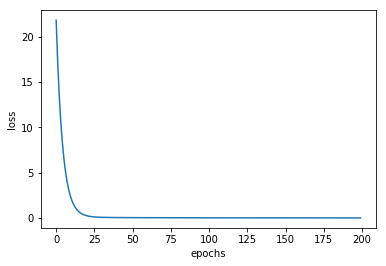

In [24]:
plt.xlabel('epochs')
plt.ylabel('loss')

# plt.yscale('log')

plt.plot(losses)

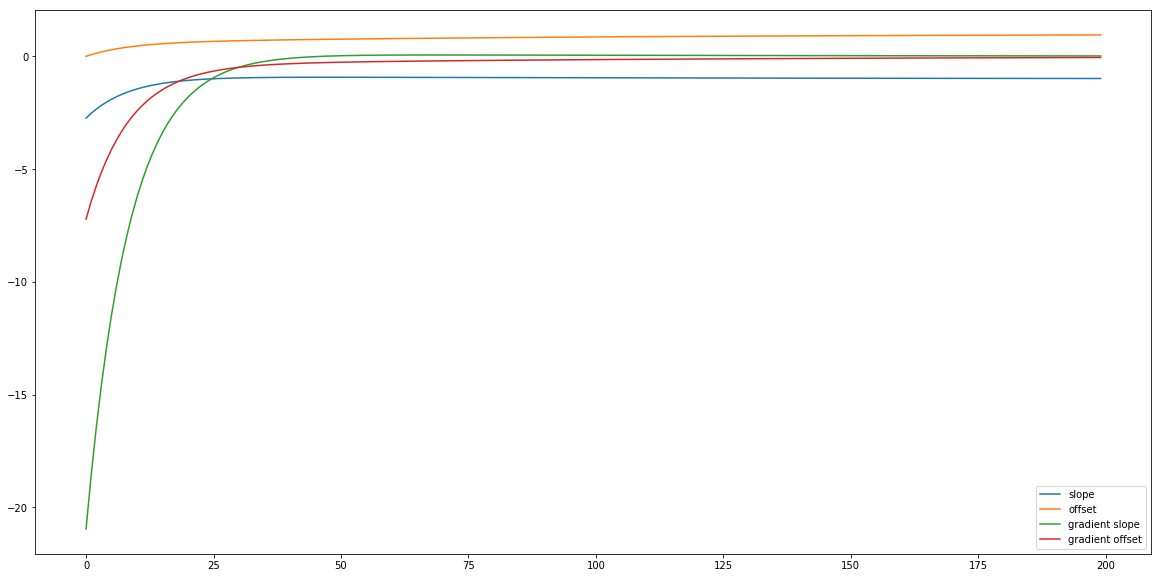

In [25]:
plt.figure(figsize=(20, 10))

plt.plot(weights)
plt.plot(biases)
plt.plot(weights_gradient)
plt.plot(biases_gradient)

plt.legend(['slope', 'offset', 'gradient slope', 'gradient offset'])

### Line drawn by neuron after training

* result after training is not perfect, but almost looks like the same line
* https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form


In [26]:
y_pred = linear_layer(x)
y_pred

<tf.Tensor: id=12136, shape=(6, 1), dtype=float32, numpy=
array([[ 1.9339795 ],
       [ 0.9500808 ],
       [-0.03381795],
       [-1.0177166 ],
       [-2.0016155 ],
       [-2.9855142 ]], dtype=float32)>

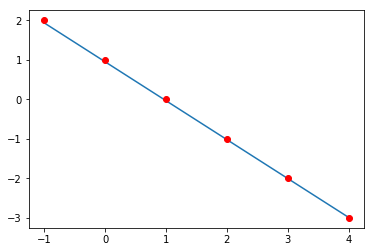

In [27]:
plt.plot(x, y_pred)
plt.plot(input, output, 'ro')

In [28]:
# single neuron and single input: one weight and one bias
# slope m ~ -1
# y-axis offset y0 ~ 1
# https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form

linear_layer.trainable_weights

[<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.98389876]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.9500808], dtype=float32)>]

### Prebuilt Optimizers do this job (but a bit more efficient and sohpisticated)

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

In [0]:
EPOCHS = 500

losses = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = linear_layer(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  losses.append(loss)
     
  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

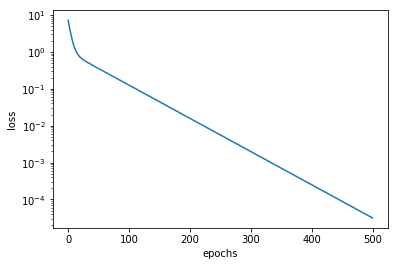

In [31]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses)

[<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.9976219]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.99262714], dtype=float32)>]

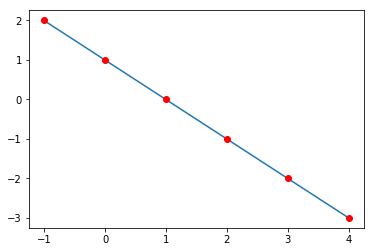

In [32]:
y_pred = linear_layer(x)
plt.plot(x, y_pred)
plt.plot(input, output, 'ro')
linear_layer.trainable_weights

## More data points, more noisy

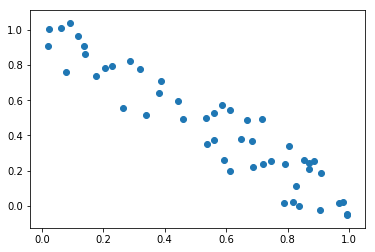

In [33]:
import numpy as np

a = -1
b = 1
n = 50

x = tf.constant(np.random.uniform(0, 1, n), dtype='float32')
y = tf.constant(a*x+b + 0.1 * np.random.normal(0, 1, n), dtype='float32')

plt.scatter(x, y)

In [0]:
x = tf.reshape(x, (n, 1))
y_true = tf.reshape(y, (n, 1))

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7f06c0204e80>])

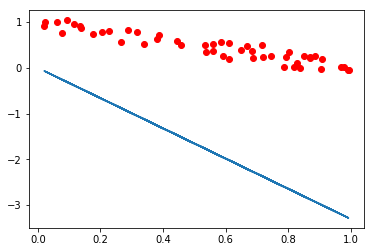

In [35]:
linear_layer = LinearLayer()

a = linear_layer.w.numpy()[0][0]
b = linear_layer.b.numpy()[0]

def plot_line(a, b, x, y_true):
  fig, ax = plt.subplots()
  y_pred = a * x + b
  
  line = ax.plot(x, y_pred)
  ax.plot(x, y_true, 'ro')
  return fig, line

plot_line(a, b, x, y_true)

In [0]:
# the problem is a little bit harder, train for a little bit longer
EPOCHS = 2000

losses = []

# stores intermediate versions of our line
lines = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = linear_layer(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  losses.append(loss)
  
  a = linear_layer.w.numpy()[0][0]
  b = linear_layer.b.numpy()[0]
  lines.append((a, b))
     
  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

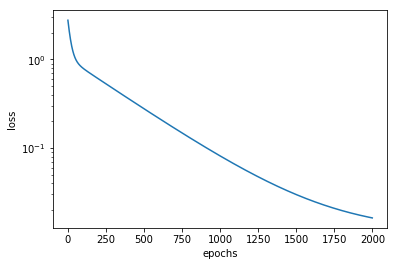

In [37]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses)

### What lines the model draws over time

#### After 0, 500, 100 steps

Text(0.5, 1.0, '0')

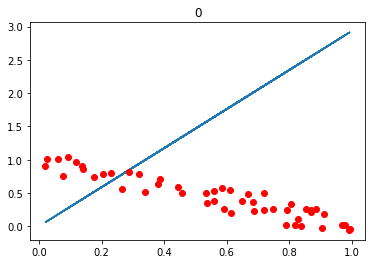

In [38]:
a, b = lines[0]

plot_line(a, b, x, y_true)
plt.title('0')

Text(0.5, 1.0, '500')

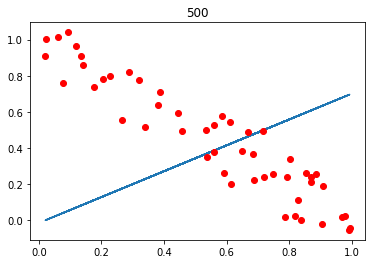

In [39]:
a, b = lines[500]

plot_line(a, b, x, y_true)
plt.title('500')

Text(0.5, 1.0, '1000')

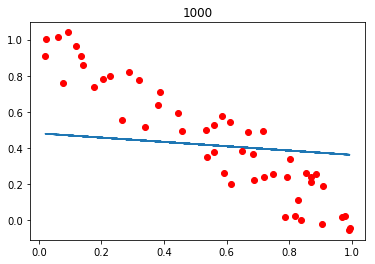

In [40]:
a, b = lines[1000]

plot_line(a, b, x, y_true)
plt.title('1000')

Text(0.5, 1.0, '2000, Final')

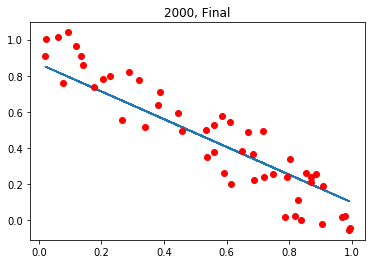

In [41]:
a, b = lines[1999]

plot_line(a, b, x, y_true)
plt.title('2000, Final')

## Understandinging the effect of activation functions

Typically, the output of a neuron is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/neuron.jpg'>

### Typical Activation Functions

<img src='https://djcordhose.github.io/ai/img/activation-functions.jpg'>


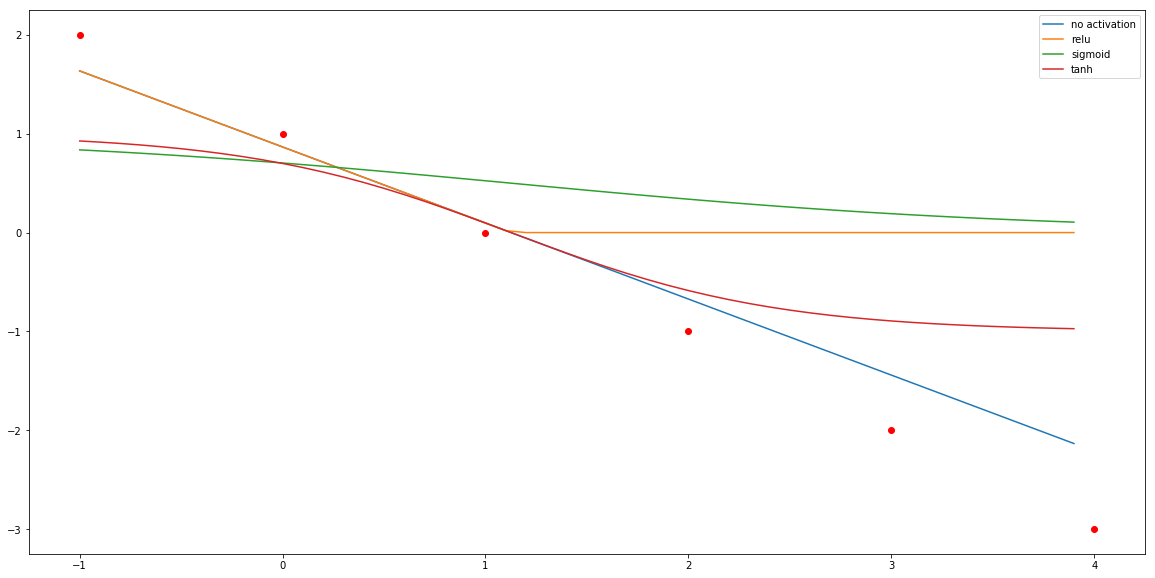

In [42]:
x = tf.reshape(tf.constant(tf.range(-1, 4, 0.1)), (50, 1))
y_pred = linear_layer(x)

plt.figure(figsize=(20, 10))

plt.plot(x, y_pred)

y_pred_relu = tf.nn.relu(y_pred)
plt.plot(x, y_pred_relu)

y_pred_sigmoid = tf.nn.sigmoid(y_pred)
plt.plot(x, y_pred_sigmoid)

y_pred_tanh = tf.nn.tanh(y_pred)
plt.plot(x, y_pred_tanh)

plt.plot(input, output, 'ro')

plt.legend(['no activation', 'relu', 'sigmoid', 'tanh'])

## Logictic Regression

So far we were inferring a continous value for another, now we want to classify. Imagine we have a line that separates two categories in two dimensions.

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

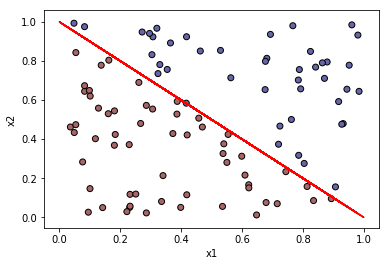

In [43]:
from matplotlib.colors import ListedColormap

a = -1
b = 1
n = 100

# all points
X = np.random.uniform(0, 1, (n, 2))

# our line
line_x = np.random.uniform(0, 1, n)
line_y = a*line_x+b
plt.plot(line_x, line_y, 'r')

# below and above line
y = X[:, 1] > a*X[:, 0]+b
y = y.astype(int)

plt.xlabel("x1")
plt.ylabel("x2")

plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['#AA6666', '#6666AA']), marker='o', edgecolors='k')
y

### We compress output between 0 and 1 using sigmoid to match y
* everything below 0.5 counts as 0, everthing above as 1

In [0]:
class SigmoidLayer(LinearLayer):
  """y = sigmoid(w.x + b)"""

  def __init__(self, **kwargs):
      super(SigmoidLayer, self).__init__(**kwargs)

  def call(self, inputs):
      return tf.sigmoid(super().call(inputs))


### We have 2d input now

In [45]:
x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')
x.shape

TensorShape([100, 2])

In [0]:
model = SigmoidLayer(input_dim=2)

### Reconsidering the loss function

_cross entropy is an alternative to squared error_ 

* cross entropy can be used as an error measure when a network's outputs can be thought of as representing independent hypotheses
* activations can be understood as representing the probability that each hypothesis might be true
* the loss indicates the distance between what the network believes this distribution should be, and what the teacher says it should be 

http://www.cse.unsw.edu.au/~billw/cs9444/crossentropy.html

In [0]:
loss_fn = tf.losses.binary_crossentropy

In [0]:
# standard optimizer using advanced properties
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

In [0]:
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics/Accuracy
m = tf.keras.metrics.Accuracy()

In [50]:
EPOCHS = 1000

losses = []
accuracies = []

for step in range(EPOCHS):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = model(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))

  y_pred_binary = (tf.squeeze(y_pred) > 0.5).numpy().astype(float)
  m.update_state(tf.squeeze(y_true), y_pred_binary)
  accuracy = m.result().numpy()

  losses.append(loss)
  accuracies.append(accuracy)
     
  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, model.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

W0606 08:07:59.246994 139668941432704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1221: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [51]:
print(loss)

tf.Tensor(0.08564544, shape=(), dtype=float32)


In [52]:
print(accuracy)

0.96995


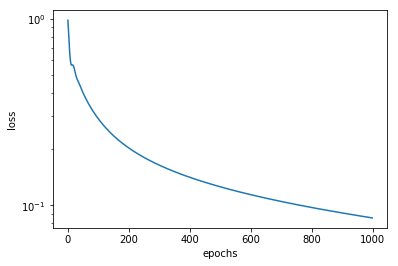

In [53]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses)

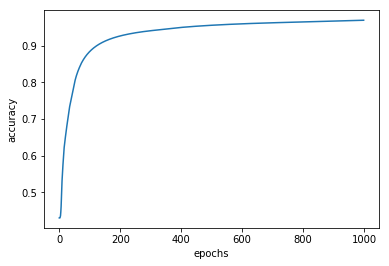

In [54]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(accuracies)

In [99]:
# tf.squeeze removes addional 1-dim dimensions
y_pred = tf.squeeze(model(x))
y_pred

<tf.Tensor: id=308404, shape=(100,), dtype=float32, numpy=
array([9.99999166e-01, 1.00000000e+00, 8.29137266e-01, 1.36425793e-02,
       9.23871994e-07, 9.99987841e-01, 3.01003456e-06, 4.14296985e-03,
       9.31193590e-01, 9.99999881e-01, 7.61583507e-01, 9.99711514e-01,
       2.54909426e-01, 9.99999881e-01, 4.02808189e-04, 9.97554064e-01,
       9.97984529e-01, 2.41258740e-03, 5.44986725e-02, 1.16825104e-05,
       9.98980880e-01, 9.99949336e-01, 1.00000000e+00, 3.04579735e-05,
       2.62260437e-06, 0.00000000e+00, 9.99865413e-01, 7.34512806e-01,
       1.00000000e+00, 4.97817993e-04, 9.99999642e-01, 1.99675560e-06,
       6.74933195e-03, 0.00000000e+00, 1.12938881e-03, 1.57356262e-04,
       1.00000000e+00, 8.45201492e-01, 3.47147882e-02, 9.99995828e-01,
       1.00000000e+00, 9.85784173e-01, 1.04627311e-02, 3.24010849e-03,
       4.01526690e-04, 8.92192125e-04, 1.46031380e-06, 3.65447402e-01,
       0.00000000e+00, 1.59778923e-01, 0.00000000e+00, 9.99686003e-01,
       9.99482751e

## We are drawing a sigmoid in 3d and turn it into a step

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/logistic.jpg?raw=1'>

In [101]:
# everything below 0.5 counts as 0, everthing above as 1
# effectively turning this into a step
y_pred_binary = (y_pred > 0.5).numpy().astype(float)
y_pred_binary

array([1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])

In [102]:
y_true - y_pred_binary

<tf.Tensor: id=308413, shape=(100,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

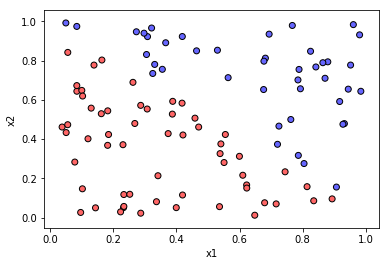

In [103]:
# below and above line

plt.xlabel("x1")
plt.ylabel("x2")

plt.scatter(X[:,0], X[:,1], c=y_pred_binary, cmap=ListedColormap(['#FF6666', '#6666FF']), marker='o', edgecolors='k')

In [0]:
# for interactive 3d on local jupyer notebook

# %matplotlib notebook

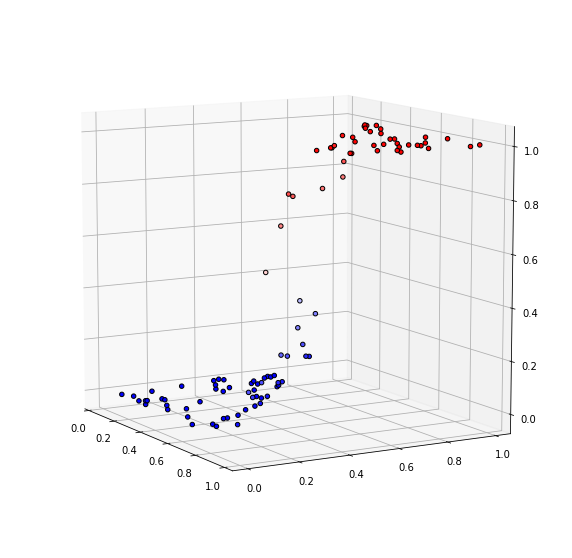

In [133]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred, 
#            https://matplotlib.org/3.1.0/gallery/color/colormap_reference.html
           cmap=plt.cm.bwr,
           depthshade=False,
           marker='o', edgecolors='k')

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=10, azim=-30)

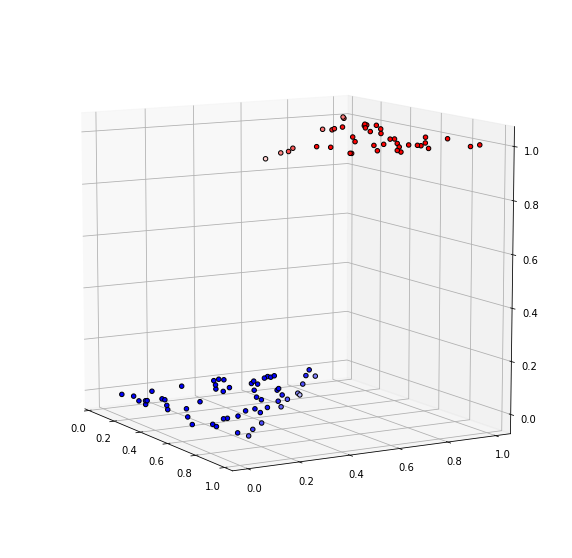

In [134]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y_pred_binary, c=y_pred, 
           cmap=plt.cm.bwr,
           depthshade=False,
           marker='o', edgecolors='k')

ax.view_init(elev=10, azim=-30)

## The same solution using high level Keas API

In [61]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential()

model.add(Dense(units=1, activation='sigmoid', input_dim=2))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [62]:
%%time 

model.compile(loss=loss_fn, # binary cross entropy, unchanged from low level example
             optimizer=optimizer, # adam, unchanged from low level example
             metrics=['accuracy'])

# does a similar thing internally as our loop from above
history = model.fit(x, y_true, epochs=EPOCHS, verbose=0)

CPU times: user 8.89 s, sys: 799 ms, total: 9.69 s
Wall time: 7.83 s


In [63]:
loss, accuracy = model.evaluate(x, y_true)
loss, accuracy

100/100 [==============================] - 0s 346us/sample - loss: 0.0517 - accuracy: 0.9900


(0.051746213734149935, 0.99)

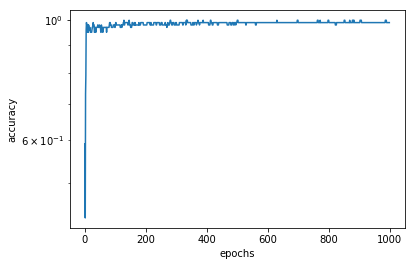

In [64]:
plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])

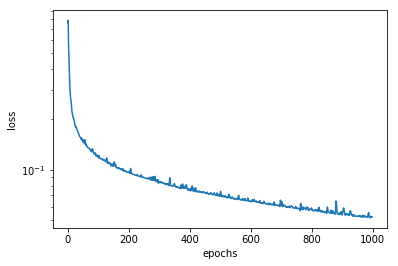

In [65]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])

In [0]:
y_pred = model.predict(x)
y_pred_binary = (tf.squeeze(y_pred) > 0.5).numpy().astype(float)

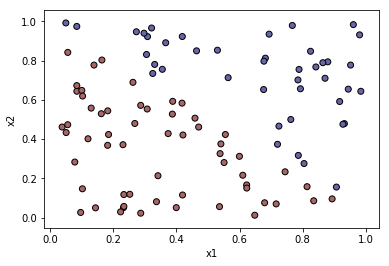

In [67]:
# below and above line

plt.xlabel("x1")
plt.ylabel("x2")

plt.scatter(X[:,0], X[:,1], c=y_pred_binary, cmap=ListedColormap(['#AA6666', '#6666AA']), marker='o', edgecolors='k')

## From single neuron to network in the TensorFlow Playground

<img src='https://djcordhose.github.io/ai/img/tf-plaground.png'>

https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.98437&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

### Applying backprop to a complex network

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/backprop.png?raw=1'>

https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/